<a href="https://colab.research.google.com/github/Sidra-g/Deep-Learning/blob/main/Intel_Image_Classification_with_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import Libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint , ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 99% 343M/346M [00:01<00:00, 188MB/s]
100% 346M/346M [00:02<00:00, 181MB/s]


In [5]:
import zipfile
import os

# Update this path based on the actual zip file location
zip_path = '/content/intel-image-classification.zip'

# Check if the zip file exists
if os.path.isfile(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/intel-image-classification')
    print("Extraction complete.")
else:
    print(f"Zip file not found at: {zip_path}")

Extraction complete.


In [6]:
#Set Paths
train = '/content/intel-image-classification/seg_train/seg_train'
val = '/content/intel-image-classification/seg_test/seg_test'
prediction='/content/intel-image-classification/seg_pred'

#Define image size ,epochs and batch size
img_size =150
epochs = 50
batch_size = 32

In [7]:
# Training Data generation and Augmenttation

traindata = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2,
    horizontal_flip=True
)

# No augmentation for validation
testdata = ImageDataGenerator(rescale=1./255)

In [8]:
# Create Data Generators
train_generator = traindata.flow_from_directory(
    train,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


validation_generator = traindata.flow_from_directory(
    train,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Test generator
test_generator = testdata.flow_from_directory(
    val,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## **With VGG19**

In [9]:
#Build Model , First adjust Conv Base
conv_base = keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_size, img_size, 3),
    pooling=None,
    classifier_activation="softmax",
    name="vgg19",
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Unfreeze the last 4 layers for finr tuning
for layer in conv_base.layers[-4:]:
    layer.trainable = True


# Freeze initial layers
for layer in conv_base.layers:
    layer.trainable = False

# Add custom layers on top of the base model
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))

#Compile and Train the model
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,352,070 (92.90 MB)

 Trainable params: 4,327,686 (16.51 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')


history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


351/351 ━━━━━━━━━━━━━━━━━━━━ 123s 307ms/step - accuracy: 0.3476 - loss: 1.5981 - val_accuracy: 0.7496 - val_loss: 0.7913 - learning_rate: 1.0000e-05
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 91s 253ms/step - accuracy: 0.6794 - loss: 0.8539 - val_accuracy: 0.7807 - val_loss: 0.6124 - learning_rate: 1.0000e-05
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 91s 256ms/step - accuracy: 0.7323 - loss: 0.6963 - val_accuracy: 0.8124 - val_loss: 0.5305 - learning_rate: 1.0000e-05
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 142s 255ms/step - accuracy: 0.7726 - loss: 0.6117 - val_accuracy: 0.8156 - val_loss: 0.5016 - learning_rate: 1.0000e-05
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 145s 263ms/step - accuracy: 0.7908 - loss: 0.5570 - val_accuracy: 0.8320 - val_loss: 0.4625 - learning_rate: 1.0000e-05
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 142s 263ms/step - accuracy: 0.8076 - loss: 0.5207 - val_accuracy: 0.8356 - val_loss: 0.4525 - learning_rate: 1.0000e-05
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 137s 250ms/st

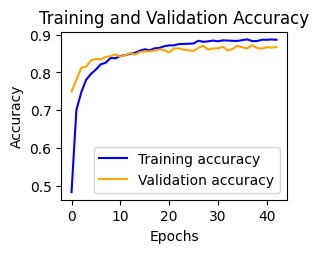

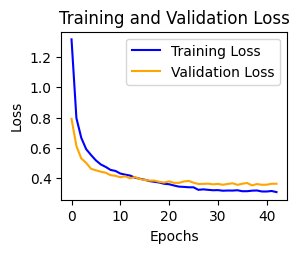

In [15]:
# Plot training accuracy with a specific color

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], color='blue', label='Training accuracy')

# Plot validation accuracy with a specific color
plt.plot(history.history['val_accuracy'], color='orange', label='Validation accuracy')

# Add labels, title, and legend for better understanding
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.show()


# Plot training loss with a specific color
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], color='blue', label='Training Loss')

# Plot validation loss with a specific color
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')

# Add labels, title, and legend for better understanding
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plot
plt.show()

In [34]:
# Evaluate the Model
print("Evaluating the model...")
# Evaluate on the training data
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
# Evaluate on the test (validation) data
test_loss, test_acc = model.evaluate(validation_generator, verbose=0)
# Print the evaluation results in a concise format
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")

Evaluating the model...
Training Loss: 0.2748, Training Accuracy: 89.92%
Test Loss: 0.3588, Test Accuracy: 86.77%


In [32]:
# Predict the test set and print additional details
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
labels = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(labels, predicted_classes, target_names=class_labels))


88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step

Classification Report:
              precision    recall  f1-score   support

   buildings       0.18      0.17      0.17       438
      forest       0.15      0.15      0.15       454
     glacier       0.16      0.15      0.15       480
    mountain       0.18      0.18      0.18       502
         sea       0.17      0.18      0.17       454
      street       0.16      0.16      0.16       476

    accuracy                           0.17      2804
   macro avg       0.17      0.17      0.17      2804
weighted avg       0.17      0.17      0.17      2804



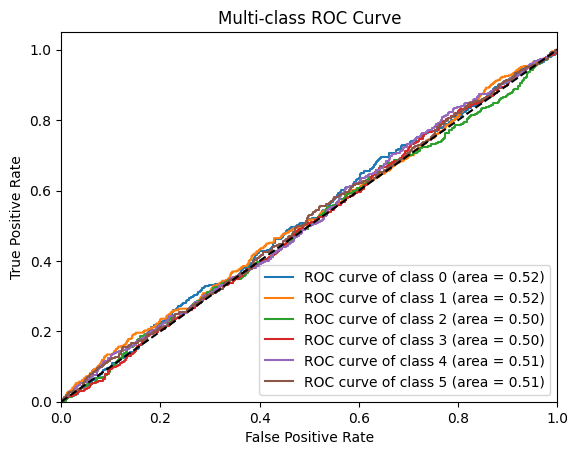

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multi-class ROC calculation
y_true_bin = label_binarize(validation_generator.classes, classes=np.unique(validation_generator.classes))
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {i} (area = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [23]:
# Normalize Prediction Data set

import tensorflow as tf

# Assuming 'prediction' is the path to your prediction image directory
prediction_ds = tf.keras.preprocessing.image_dataset_from_directory(
    prediction,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_size, img_size),  # Use the same image size as training
    interpolation='nearest',  # Or other interpolation method
    batch_size=batch_size,
    shuffle=False
)

def process(image,label):
    image = tf.cast(image, tf.float32) / 255.  # Cast image to float32 before division
    return image,label

prediction_ds = prediction_ds.map(process)

Found 7301 files belonging to 1 classes.


In [25]:
print(validation_generator.class_indices)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [26]:
# Reverse the mapping
index_to_class = {v: k for k, v in validation_generator.class_indices.items()}
print(index_to_class)

{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


In [28]:
predicted_classes = np.argmax(y_pred, axis=1)

# Map predicted indices to class names
predicted_labels = [index_to_class[i] for i in predicted_classes]
print(predicted_labels)

['street', 'glacier', 'forest', 'mountain', 'forest', 'street', 'street', 'buildings', 'glacier', 'sea', 'street', 'mountain', 'street', 'glacier', 'street', 'sea', 'sea', 'forest', 'sea', 'buildings', 'sea', 'mountain', 'mountain', 'buildings', 'mountain', 'glacier', 'mountain', 'mountain', 'mountain', 'sea', 'street', 'sea', 'buildings', 'mountain', 'sea', 'street', 'mountain', 'mountain', 'sea', 'mountain', 'street', 'mountain', 'mountain', 'buildings', 'sea', 'mountain', 'glacier', 'street', 'glacier', 'mountain', 'glacier', 'sea', 'sea', 'sea', 'glacier', 'buildings', 'mountain', 'street', 'mountain', 'sea', 'street', 'forest', 'street', 'glacier', 'sea', 'forest', 'forest', 'glacier', 'sea', 'sea', 'buildings', 'street', 'buildings', 'sea', 'mountain', 'buildings', 'mountain', 'mountain', 'mountain', 'glacier', 'mountain', 'buildings', 'street', 'buildings', 'sea', 'forest', 'mountain', 'street', 'street', 'forest', 'glacier', 'forest', 'mountain', 'mountain', 'sea', 'street', 's

In [29]:
# Create a DataFrame for predictions
df = pd.DataFrame({"Predicted Label": predicted_labels,"Class":predicted_classes})

# Save to a CSV file
df.to_csv("predictions.csv", index=False)
